# Machine Learning Essentials sheet 03

<div style="color: green; font-weight:bold"> This is the easy part of the exercise, which is just copying and pasting the code. Therefore, the same result as the worked example.</div>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy

In [2]:
plt.rc("figure", dpi=100)

batch_size = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

In [3]:
def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    w.requires_grad = True
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)

In [4]:
class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])


In [5]:
# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax


# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

Epoch: 0
Mean Train Loss: 3.98e-01
Mean Test Loss:  2.01e-01
Epoch: 10
Mean Train Loss: 1.40e-01
Mean Test Loss:  2.68e-01
Epoch: 20
Mean Train Loss: 1.05e-01
Mean Test Loss:  4.61e-01
Epoch: 30
Mean Train Loss: 7.62e-02
Mean Test Loss:  5.93e-01
Epoch: 40
Mean Train Loss: 4.73e-02
Mean Test Loss:  7.18e-01
Epoch: 50
Mean Train Loss: 3.55e-02
Mean Test Loss:  6.62e-01
Epoch: 60
Mean Train Loss: 3.73e-02
Mean Test Loss:  7.82e-01
Epoch: 70
Mean Train Loss: 2.37e-02
Mean Test Loss:  7.97e-01
Epoch: 80
Mean Train Loss: 1.75e-02
Mean Test Loss:  8.78e-01
Epoch: 90
Mean Train Loss: 1.35e-02
Mean Test Loss:  9.13e-01
Epoch: 100
Mean Train Loss: 1.12e-02
Mean Test Loss:  8.86e-01


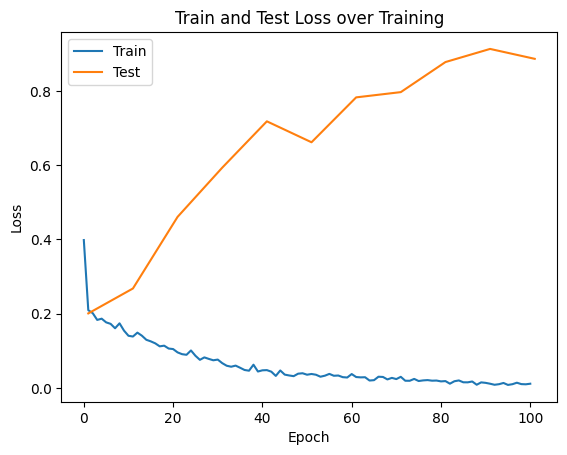

In [6]:
# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

<div style="color: green; font-weight:bold"> The dropout function is what it should be. However, Bernoulli distribution is used, which is a special case of the binomial distribution </div>

In [7]:
def dropout(X, p_drop=0.5):
    if 0 < p_drop < 1:
        # Copy input tensor
        X_0 = X.clone()

        # Get length for drawing
        shape = X_0.shape

        # Draw from a binomial distribution, get the same length as X
        Phi = torch.bernoulli(torch.full(shape, p_drop))

        # Modify X_0 based on the values in Phi
        X_modified = torch.where(Phi == 1, torch.zeros_like(X_0), X_0 / (1 - p_drop))

        # Cast into torch tensor
        return X_modified

    else:
        # Return original X if p_drop has no probability
        return X

In [8]:
def dropout_model (X , w_h , w_h2 , w_o , p_drop_input , p_drop_hidden ):
    X_drop = dropout(X, p_drop_input)
    h = rectify(X_drop @ w_h)
    h_drop = dropout(h, p_drop_hidden)
    h2 = rectify(h_drop @ w_h2)
    h2_drop = dropout(h2, p_drop_hidden)
    pre_softmax = h2_drop @ w_o
    return pre_softmax


# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

p_drop_input = 0.5
p_drop_hidden = 0.5

optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

Epoch: 0
Mean Train Loss: 1.01e+00
Mean Test Loss:  3.33e-01
Epoch: 10
Mean Train Loss: 1.02e+00
Mean Test Loss:  3.08e-01
Epoch: 20
Mean Train Loss: 1.28e+00
Mean Test Loss:  3.98e-01
Epoch: 30
Mean Train Loss: 1.43e+00
Mean Test Loss:  4.08e-01
Epoch: 40
Mean Train Loss: 1.66e+00
Mean Test Loss:  4.67e-01
Epoch: 50
Mean Train Loss: 1.76e+00
Mean Test Loss:  5.69e-01
Epoch: 60
Mean Train Loss: 1.83e+00
Mean Test Loss:  5.84e-01
Epoch: 70
Mean Train Loss: 1.96e+00
Mean Test Loss:  6.02e-01
Epoch: 80
Mean Train Loss: 2.10e+00
Mean Test Loss:  6.88e-01
Epoch: 90
Mean Train Loss: 2.17e+00
Mean Test Loss:  6.66e-01
Epoch: 100
Mean Train Loss: 2.18e+00
Mean Test Loss:  6.63e-01


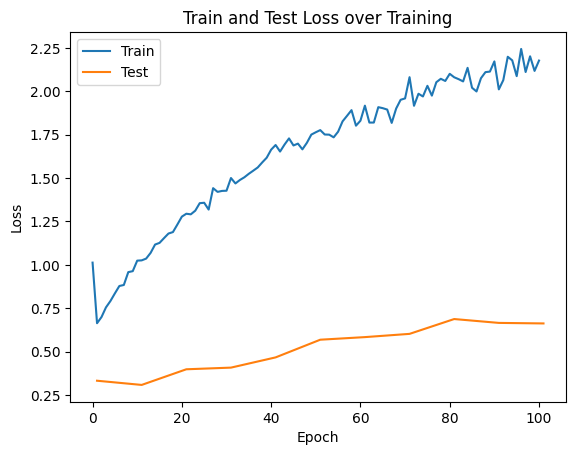

In [9]:
# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = dropout_model(x, w_h, w_h2, w_o, p_drop_input , p_drop_hidden )

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = dropout_model(x, w_h, w_h2, w_o, 0, 0)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

<div style="color: green; font-weight:bold"> The explanation of overfitting and the effect of dropout funnction on it is good.</div>

## Explanation:
### Why reduction of overfitting:
The dropout function works in such a way that the portion p_drop of the input is masked with 0, so that random values of the input are missing. The network cannot learn anything from these missing values. The values that are not set to 0 are divided with the counter probability, i.e. scaled up proportionally, so that the sum of all input values does not change so much. This reduces the risk of wrong threshold values for parameters being assumed for non-masked inputs of the same size. In overfitting, the parameters are fitted too precisely to the training data, due to the missing values, there are always values that do not fit this scheme, so there is less data that leads to overfitting. Overall, overfitting is thus reduced.

### Why a different model configuration for evaluationg the test loss?
Masking of values is only needed for the training process. When evaluating on the test data, it should be checked whether the test data are classified correctly. Removing test data is unnecessary, because the parameters are not changed during testing. If the test data is also masked, this leads to a higher test loss, which does not correspond to reality. For this reason, the model used when evaluating the test set must not contain any dropout.

### Comparison of test errors
As can be seen very well, the training loss increases with increasing training, which is due to the fact that different data is seen in each epoch and therefore it is difficult for the network to learn in this configuration. Actually, the training loss should decrease. In contrast to the original model, however, we can see here that the test loss is significantly lower than the training loss, which again shows that overfitting does not occur as strongly here as before. In addition, the loss is smaller than that of the original model.


## 3 Parametric Relu

<div style="color: green; font-weight:bold"> The PRelu is correctly defined (although it could be defined more simply using `where`). The accuracy is improved, compared to the previous models, same as the author's solution.</div>

In [21]:
def PRelu (X , a ) :
    # Repeat a to get matrix of same size as X
    a_matrix = a.unsqueeze(0).repeat(X.shape[0], 1)

    # Implement f(y_i) = max(0, y_i) + a_i * min(0, y_i)
    result = torch.max(torch.zeros_like(X), X) + torch.mul(a_matrix, torch.min(torch.zeros_like(X), X))
    return result


In [22]:
def PRelu_model (X , w_h , w_h2 , w_o , a, a2, p_drop_input , p_drop_hidden ):
    # Change rectify to PRelu
    X_drop = dropout(X, p_drop_input)
    h = PRelu(X_drop @ w_h, a)
    h_drop = dropout(h, p_drop_hidden)
    h2 = PRelu(h_drop @ w_h2, a2)
    h2_drop = dropout(h2, p_drop_hidden)
    pre_softmax = h2_drop @ w_o
    return pre_softmax



# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

# Initialize a, a2
a = init_weights((625,))
a2 = init_weights((625,))


optimizer = RMSprop(params=[w_h, w_h2, w_o, a, a2])


n_epochs = 100

train_loss = []
test_loss = []

Epoch: 0
Mean Train Loss: 9.97e-01
Mean Test Loss:  4.14e-01
Epoch: 10
Mean Train Loss: 5.94e-01
Mean Test Loss:  2.06e-01
Epoch: 20
Mean Train Loss: 6.06e-01
Mean Test Loss:  2.21e-01
Epoch: 30
Mean Train Loss: 5.90e-01
Mean Test Loss:  1.93e-01
Epoch: 40
Mean Train Loss: 5.96e-01
Mean Test Loss:  1.78e-01
Epoch: 50
Mean Train Loss: 6.07e-01
Mean Test Loss:  1.84e-01
Epoch: 60
Mean Train Loss: 6.18e-01
Mean Test Loss:  1.76e-01
Epoch: 70
Mean Train Loss: 6.26e-01
Mean Test Loss:  1.77e-01
Epoch: 80
Mean Train Loss: 6.34e-01
Mean Test Loss:  1.89e-01
Epoch: 90
Mean Train Loss: 6.48e-01
Mean Test Loss:  1.83e-01
Epoch: 100
Mean Train Loss: 6.60e-01
Mean Test Loss:  1.84e-01


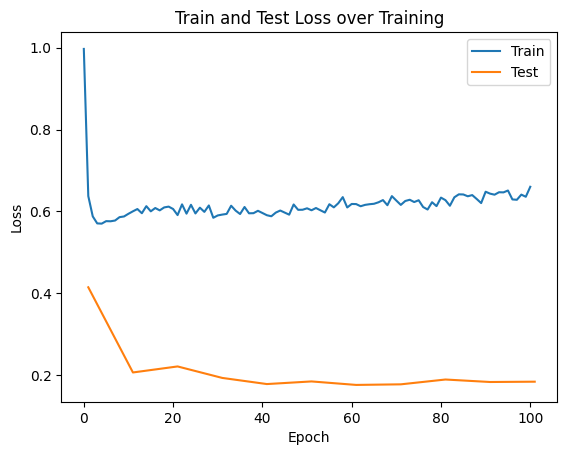

In [23]:
# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = PRelu_model(x, w_h, w_h2, w_o, a, a2, p_drop_input , p_drop_hidden )

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = PRelu_model(x, w_h, w_h2, w_o, a, a2, 0 , 0)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

#### Comparison of results
In the PRelu model, you can see that the test loss is significantly lower than the training loss and also decreases with training. In addition, the loss at the end is significantly smaller than in the previous models, which is why this network performs best so far.

### 4 Convolutional layers

![sketch of the network](ML-image4-1.png "Sketch of the network")

<div style="color: green; font-weight:bold"> Dropout isn't used for the first layer, which could make the network more prone to overfitting (but otherwise seems correct).</div>

In [38]:
def cnn(x, w_c1, w_c2, w_c3, w_h2, w_o, p_drop_input):
    # first convolutional layer
    c1 = rectify(conv2d(x, w_c1))
    s1 = max_pool2d(c1, (2,2) )
    d1 = dropout (s1, p_drop_input )

    # second convolutional layer
    c2 = rectify(conv2d(d1, w_c2))
    s2 = max_pool2d(c2, (2,2) )
    d2 = dropout(s2, p_drop_input)

    # third convolutional layer
    c3 = rectify(conv2d(d2, w_c3))
    s3 = max_pool2d(c3,(2,2))
    d3 = dropout(s3, p_drop_input)
    # flatten output
    flat = torch.reshape(d3,(x.shape[0],128))
    
    h2 = rectify(flat @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax

# initialize weights

# weight vector first layer
w_c1 = init_weights((32,1,5,5))
# weight vector second layer
w_c2 = init_weights((64,32,5,5))
# weight vector third layer
w_c3 = init_weights((128,64,2,2))
# hidden layer with 625 neurons
w_h2 = init_weights((128, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_c1, w_c2, w_c3, w_h2, w_o])


n_epochs = 100
p_drop_hidden = 0.5

train_loss = []
test_loss = []

<div style="color: green; font-weight:bold"> Dropout should NOT be used for the test data! It should be exclusively used for training, we don't want the network to perform differently each time it is used!</div>

<div style="color: green; font-weight:bold">We can fix this by setting `cnn`'s last parameter to 0 when calculating the testing loss.</div>

Epoch: 0
Mean Train Loss: 3.73e+00
Mean Test Loss:  1.15e+00
Epoch: 10
Mean Train Loss: 3.91e-01
Mean Test Loss:  3.61e-01
Epoch: 20
Mean Train Loss: 4.12e-01
Mean Test Loss:  4.13e-01
Epoch: 30
Mean Train Loss: 4.41e-01
Mean Test Loss:  4.16e-01
Epoch: 40
Mean Train Loss: 4.92e-01
Mean Test Loss:  4.05e-01
Epoch: 50
Mean Train Loss: 5.55e-01
Mean Test Loss:  4.90e-01
Epoch: 60
Mean Train Loss: 6.44e-01
Mean Test Loss:  5.63e-01
Epoch: 70
Mean Train Loss: 7.34e-01
Mean Test Loss:  6.73e-01
Epoch: 80
Mean Train Loss: 8.06e-01
Mean Test Loss:  8.38e-01
Epoch: 90
Mean Train Loss: 9.11e-01
Mean Test Loss:  7.40e-01
Epoch: 100
Mean Train Loss: 1.00e+00
Mean Test Loss:  9.90e-01


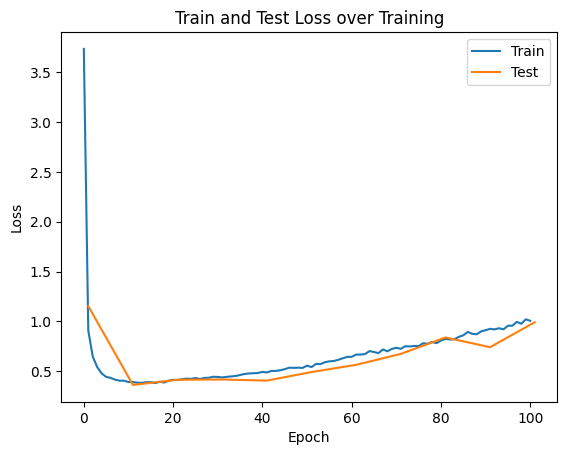

In [39]:
# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        trainX = x.reshape(-1, 1, 28, 28)
        
        # feed input through model
        noise_py_x = cnn(trainX, w_c1, w_c2, w_c3, w_h2, w_o, p_drop_input)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch

                testX = x.reshape(-1, 1, 28, 28)
                noise_py_x = cnn(testX, w_c1, w_c2, w_c3, w_h2, w_o, p_drop_input)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

<div style="color: green; font-weight:bold"> The filters are plotted correctly, but the original image by each filter is not plotted.</div>

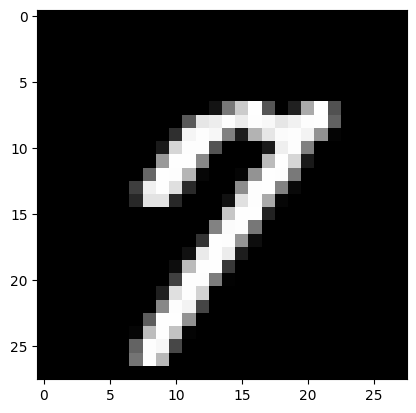

In [40]:
# Plot one image from test set
train_features, train_labels = next(iter(train_dataloader))
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()

In [41]:
# Plot its convolution with 3 filters of the first convolutional layer
img = train_features[0]
w_ctest = init_weights((3,1,5,5))
ctest = conv2d(img, w_ctest)
# output = ctest(img)
ctest.shape
test_img = ctest.detach().numpy()

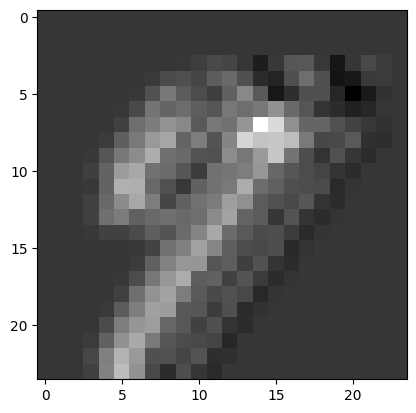

In [42]:
test_img = np.squeeze(test_img)
plt.imshow(test_img[0], cmap = 'gray')

In [43]:
# Plot the corresponding filter weights (5 by 5 images)
print(w_ctest.detach().numpy())

[[[[-0.67810225  0.97867537  0.66492367 -0.11646248  0.46595022]
   [ 0.18943213  0.9770253  -0.72156155  0.5626512   1.5680227 ]
   [-0.18519354 -1.6848849   1.76613     0.479643   -0.21590099]
   [-0.25114387 -0.8570907  -0.24699384  0.54163235  0.99336153]
   [ 0.6387027   0.05763344 -1.5220566   0.9924837   0.4126329 ]]]


 [[[-0.11640145 -0.9431292  -1.0777481  -0.00817526  1.2242206 ]
   [ 0.52382016  1.4008163   0.4469244   0.06090381  0.26371863]
   [ 0.7907737   0.4210467   0.7458526   0.09601437  0.00492938]
   [-0.14243819  0.00936471  1.2554494  -0.02316388 -0.89583576]
   [-0.17129217  0.9606521  -0.6451221   0.6005609  -0.10846293]]]


 [[[-0.40593886 -0.17080286  0.22368442 -1.3172082  -1.0364534 ]
   [-1.6450781  -0.63230824 -0.7586016   1.7907039   0.87226546]
   [ 0.9812165  -0.89888555  0.40590292 -0.14439124  1.0327789 ]
   [-0.3866571  -0.790099   -0.59975696  0.19325796 -1.842452  ]
   [-0.4539635  -0.547126   -0.66236854  0.15174073  0.08576994]]]]


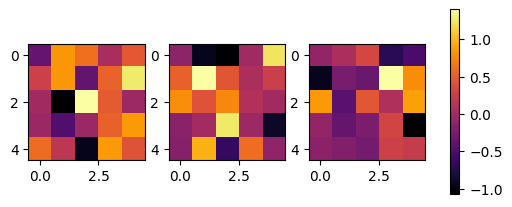

In [44]:
weight = w_ctest.detach().numpy()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
im1 = ax1.imshow(weight[0,0,:,:], cmap='inferno')
im2 = ax2.imshow(weight[1,0,:,:], cmap='inferno')
im3 = ax3.imshow(weight[2,0,:,:], cmap='inferno')
fig.colorbar(im2, ax=(ax1, ax2, ax3), orientation='vertical', shrink=0.5)
plt.show()

<div style="color: green; font-weight:bold">The conclusion is wrong here since the testing loss is calculated incorrectly (as mentioned before).</div>

### Comparison of results
It can be seen that the network has difficulty learning as both the training and test loss increase and the test loss ends up being even worse than the original model. This is probably due to the fact that not enough training data is available for such a comparatively complex network.

### 4.2 Task: Add one convolutional layer

<div style="color: green; font-weight:bold">Same problems as mentioned before (no dropout on the first layer, incorrect testing loss).</div>

In [69]:
def cnn2(x, w_c1, w_c2, w_c3, w_c4, w_h2, w_o, p_drop_input):
    # first convolutional layer
    c1 = rectify(conv2d(x, w_c1))
    s1 = max_pool2d(c1, (2,2) )
    d1 = dropout (s1, p_drop_input )

    # second convolutional layer
    c2 = rectify(conv2d(d1, w_c2))
    s2 = max_pool2d(c2, (2,2) )
    d2 = dropout(s2, p_drop_input)

    # third convolutional layer
    c3 = rectify(conv2d(d2, w_c3))
    s3 = max_pool2d(c3,(2,2))
    d3 = dropout(s3, p_drop_input)

    # fourth convolutional layer
    c4 = rectify(conv2d(d3, w_c4))
    s4 = max_pool2d(c4,(1,1))
    d4 = dropout(s4, p_drop_input)

    # flatten output
    flat = torch.reshape(d4,(x.shape[0],256))
    
    h2 = rectify(flat @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax

# initialize weights

# weight vector first layer
w_c1 = init_weights((32,1,5,5))
# weight vector second layer
w_c2 = init_weights((64,32,5,5))
# weight vector third layer
w_c3 = init_weights((128,64,2,2))
# weight vector fourth layer
w_c4 = init_weights((256, 128, 1, 1))
# hidden layer with 625 neurons
w_h2 = init_weights((256, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_c1, w_c2, w_c3, w_c4, w_h2, w_o])


n_epochs = 100
p_drop_hidden = 0.5

train_loss = []
test_loss = []

Epoch: 0
Mean Train Loss: 3.57e+00
Mean Test Loss:  1.81e+00
Epoch: 10
Mean Train Loss: 6.42e-01
Mean Test Loss:  6.49e-01
Epoch: 20
Mean Train Loss: 5.12e-01
Mean Test Loss:  5.10e-01
Epoch: 30
Mean Train Loss: 4.66e-01
Mean Test Loss:  5.36e-01
Epoch: 40
Mean Train Loss: 4.54e-01
Mean Test Loss:  4.44e-01
Epoch: 50
Mean Train Loss: 4.55e-01
Mean Test Loss:  4.38e-01
Epoch: 60
Mean Train Loss: 4.71e-01
Mean Test Loss:  4.24e-01
Epoch: 70
Mean Train Loss: 4.83e-01
Mean Test Loss:  4.34e-01
Epoch: 80
Mean Train Loss: 5.32e-01
Mean Test Loss:  4.55e-01
Epoch: 90
Mean Train Loss: 6.05e-01
Mean Test Loss:  5.71e-01
Epoch: 100
Mean Train Loss: 6.84e-01
Mean Test Loss:  6.06e-01


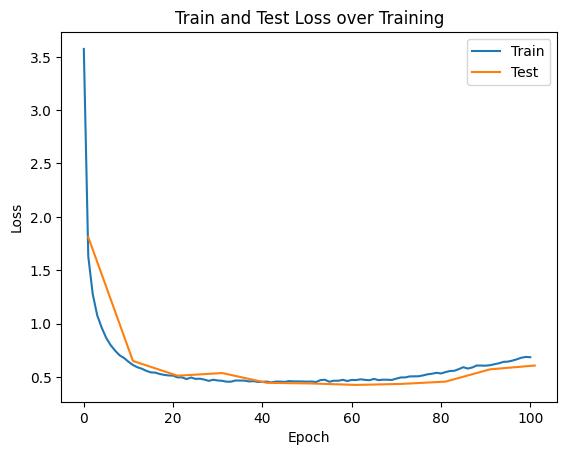

In [70]:
# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        trainX = x.reshape(-1, 1, 28, 28)
        
        # feed input through model
        noise_py_x = cnn2(trainX, w_c1, w_c2, w_c3, w_c4, w_h2, w_o, p_drop_input)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch

                testX = x.reshape(-1, 1, 28, 28)
                noise_py_x = cnn2(testX, w_c1, w_c2, w_c3, w_c4, w_h2, w_o, p_drop_input)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

### Comparison of results
As with the CNN before, the loss for testing and training increases again at the end. In the end, the network performs about as well as the dropout model.

### Overview table test errors from all sections
| Model | Test error | 
| ----- | ---------- |
| model | 0.913|
| dropout model | 0.663 |
| Prelu model | 0.184 |
| CNN | 0.990 |
| Adjusted CNN | 0.606 |

According to this execution the model with a parametric Relu and dropout performs best.